<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Dependencies" data-toc-modified-id="Dependencies-1">Dependencies</a></span></li><li><span><a href="#Functions" data-toc-modified-id="Functions-2">Functions</a></span></li><li><span><a href="#Paths" data-toc-modified-id="Paths-3">Paths</a></span></li><li><span><a href="#Main" data-toc-modified-id="Main-4">Main</a></span><ul class="toc-item"><li><span><a href="#number-of-peptides-in-immune-clusters" data-toc-modified-id="number-of-peptides-in-immune-clusters-4.1">number of peptides in immune clusters</a></span></li><li><span><a href="#TMB-and-predicted-peptide-correlation" data-toc-modified-id="TMB-and-predicted-peptide-correlation-4.2">TMB and predicted peptide correlation</a></span></li><li><span><a href="#Correlation-of-div-with-number-of-peptides" data-toc-modified-id="Correlation-of-div-with-number-of-peptides-4.3">Correlation of div with number of peptides</a></span></li><li><span><a href="#Peptide-mhcs-and-their-frequencies" data-toc-modified-id="Peptide-mhcs-and-their-frequencies-4.4">Peptide mhcs and their frequencies</a></span></li></ul></li><li><span><a href="#TableS5" data-toc-modified-id="TableS5-5">TableS5</a></span></li><li><span><a href="#Numbers-in-text" data-toc-modified-id="Numbers-in-text-6">Numbers in text</a></span></li><li><span><a href="#Deprecated" data-toc-modified-id="Deprecated-7">Deprecated</a></span></li></ul></div>

# Dependencies

In [1]:
options(scipen = 999)

In [2]:
library(ggplot2)
library(ggbeeswarm)
library(Hmisc)
library(reshape2)
library(car)

Loading required package: lattice

Loading required package: survival

Loading required package: Formula


Attaching package: ‘Hmisc’


The following objects are masked from ‘package:base’:

    format.pval, units


Loading required package: carData



# Functions

In [3]:
source("~/OneDrive - UHN//R_src/ggplot2_theme.R")

# Paths

In [4]:
datapath <- "/Users/anabbi/OneDrive - UHN/Documents/IPD2/Data/"
plotpath <- "/Users/anabbi/OneDrive - UHN/Documents/IPD2/Plots/"

# Main

In [5]:
load( file = paste0(datapath, "diversity/metadata_IC_TRA.RData"))
load( file = paste0(datapath, "diversity/metadata_IC_TRB.RData"))

In [6]:
load(file = file.path(datapath,"TME_clusters/IPD_estimate_metadata_IC.RData"))

In [7]:
load(file = paste0(datapath,"snv/total_mut_manifest_estimate.RData"))

In [8]:
ped <- total_mut_manifest_estimate[total_mut_manifest_estimate$group != "TCGA",]

In [9]:
colnames(metadata_IC)

[1] "aliquot_id"       "StromalScore"     "ImmuneScore"      "ESTIMATEScore"   
 [5] "name"             "case_id"          "sample_id"        "gender"          
 [9] "ethnicity"        "race"             "age_at_diagnosis" "vital_status"    
[13] "days_to_death"    "days_to_progress" "recurrence"       "disease_type"    
[17] "primary_site"     "group"            "cohort"           "sample_type"     
[21] "age_class"        "tumour_subtype"   "CRI_cluster"      "immune_cluster"

In [10]:
metadata_IC$percread <- 8.0947988*exp(metadata_IC$ImmuneScore*0.0006267)

In [11]:
mupexifiles <- list.files(paste0(datapath, "Mupexi/"), 
                          pattern = "_all.mupexi", recursive = T)

In [12]:
all.mupexifiles <- lapply(mupexifiles, function(f){read.table(paste0(datapath,"Mupexi/",f), header = TRUE, sep = "\t", stringsAsFactors = F)})

In [13]:
all.mupexi <- do.call("rbind", all.mupexifiles)

In [14]:
colnames(all.mupexi)

[1] "HLA_allele"             "Norm_peptide"           "Norm_MHCrank_EL"       
 [4] "Norm_MHCscore_EL"       "Norm_MHCaffinity"       "Norm_MHCrank_BA"       
 [7] "Norm_MHCscore_BA"       "Mut_peptide"            "Mut_MHCrank_EL"        
[10] "Mut_MHCscore_EL"        "Mut_MHCaffinity"        "Mut_MHCrank_BA"        
[13] "Mut_MHCscore_BA"        "Gene_ID"                "Transcript_ID"         
[16] "Amino_Acid_Change"      "Allele_Frequency"       "Mismatches"            
[19] "peptide_position"       "Chr"                    "Genomic_Position"      
[22] "Protein_position"       "Mutation_Consequence"   "Gene_Symbol"           
[25] "Cancer_Driver_Gene"     "Proteome_Peptide_Match" "Expression_Level"      
[28] "Mutant_affinity_score"  "Normal_affinity_score"  "Expression_score"      
[31] "priority_Score"         "Norm_MHCbinder"         "Mut_MHCbinder"         
[34] "sample_id"

In [15]:
dim(all.mupexi)

[1] 1370753      34

In [31]:
bindersamples <- all.mupexi[!is.na(all.mupexi$Mut_MHCbinder)  ,]

## number of peptides in immune clusters

In [32]:
# subest to include only those samples with available mupexi files and having Strong binders
metadata_IC_SB <- metadata_IC[ metadata_IC$sample_id %in% bindersamples$sample_id,]

In [33]:
dim(metadata_IC_TRB_SB)

[1] 241  38

In [34]:
#some of these samples dont have predicted peptides with SB
tmp <- as.data.frame(table(bindersamples$sample_id), stringsAsFactors = F)

In [35]:
head(tmp)

,Var1,Freq
,<chr>,<int>
1,7316-10,20
2,7316-101,26
3,7316-1075,2
4,7316-1078,82
5,7316-1081,46
6,7316-1082,3


In [36]:
metadata_IC_TRB_SB$binders <- NA

for(i in 1:nrow(tmp)){
    metadata_IC_TRB_SB$binders[match(tmp$Var1[i],metadata_IC_TRB_SB$sample_id)] <- tmp$Freq[i]   
}

metadata_IC_TRB_SB$binders[is.na(metadata_IC_TRB_SB$binders)] <- 0

In [41]:
rcorr(div_trb$estimated_Shannon, div_trb$binders,  type = "spearman")

     x    y
x 1.00 0.14
y 0.14 1.00

n= 184 


P
  x      y     
x        0.0524
y 0.0524       

In [37]:
pep_div_p <- ggplot(data = div_trb, aes(y = estimated_Shannon, x = binders, color = cohort, size = mutpermb)) + 
geom_point() + mytheme +
scale_y_continuous(trans = "log10") + 
scale_x_continuous(trans = "log10") +
annotation_logticks(sides = "bl") +
scale_color_manual(values = colpal) +
scale_size_continuous(range = c(3, 15), breaks=c(0.2,1,2, 10)) +
labs( x = "Number of predicted peptides", y = "Inferred Shannon diversity")

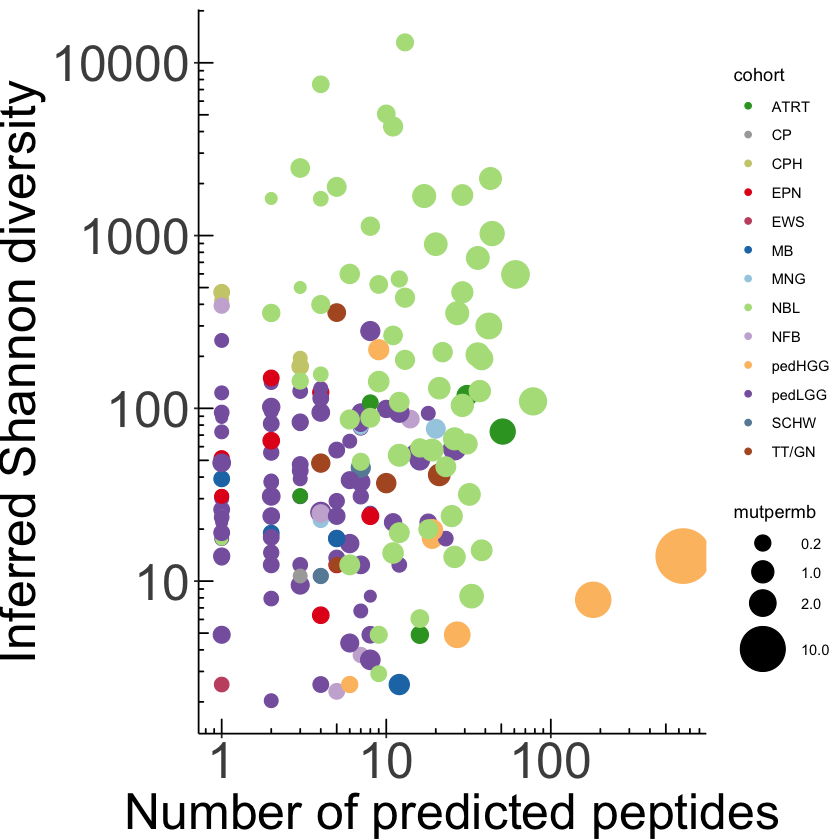

In [38]:
pep_div_p

In [101]:
pdf(file = paste0(plotpath,"peptide_TMB_TRBdiv_plot.pdf"),
    width = 10, 
    height = 10,
    useDingbats = FALSE)
pep_div_p
dev.off()

pdf 
  2

## TMB and predicted peptide correlation

In [21]:
table(total_mut_manifest_estimate$group)


 CBTTC   DKFZ TARGET   TCGA 
   471    196     98   2336 

In [22]:
ped <- total_mut_manifest_estimate[total_mut_manifest_estimate$group != "TCGA",]

In [23]:
table(all.mupexi$Mut_MHCbinder[all.mupexi$sample_id %in% ped$sample_id])


   SB    WB 
 6514 18746 

In [24]:
bindersamples <- all.mupexi[all.mupexi$Mut_MHCbinder == "SB" ,]

In [25]:
peptide_table <- as.data.frame(table(bindersamples$sample_id), stringsAsFactors = F)

In [26]:
colnames(peptide_table) <- c("sample_id", "peptides_SB")

In [27]:
ped_peptide <- merge(ped, peptide_table, by = "sample_id")

In [28]:
dim(ped_peptide)

[1] 456  35

In [29]:
regression_peptide <- lm( log10(mutpermb)~ log10(peptides_SB), data = ped_peptide)

summary(regression_peptide)


Call:
lm(formula = log10(mutpermb) ~ log10(peptides_SB), data = ped_peptide)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.08745 -0.14516  0.01379  0.17735  0.60332 

Coefficients:
                   Estimate Std. Error t value            Pr(>|t|)    
(Intercept)        -1.17776    0.02454  -47.99 <0.0000000000000002 ***
log10(peptides_SB)  0.64015    0.02476   25.86 <0.0000000000000002 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.2686 on 454 degrees of freedom
Multiple R-squared:  0.5956,	Adjusted R-squared:  0.5947 
F-statistic: 668.7 on 1 and 454 DF,  p-value: < 0.00000000000000022


In [31]:
colpal <- c("MB_PDX" = "#878787", #PDX
            "ETMR" = "#76afa9", #ped
            "MNG" = "#a6cee3", 
            "MB" =  "#1f78b4",
            "SCHW" =  "#678ba5",
            "ATRT" =  "#33a02c",
            "EPN" = "#e31a1c",
            "pedHGG" = "#fdbf6f",
            "pedLGG" = "#8763ae",
            "NFB" = "#cab2d6",
            "CPH" = "#cccc7a",
            "CP" = "#a9a9a9",
            "NBL" = "#b2df8a"
)

In [33]:
pep_p <- ggplot(data = ped_peptide, aes(y = peptides_SB, x = mutpermb, color = cohort)) + geom_point(size = 5) + 
myaxis + myplot +
scale_y_continuous(trans = "log10") + 
scale_x_continuous(trans = "log10") +
annotation_logticks(sides = "bl") +
scale_color_manual(values = colpal) +
labs(y = "Number of predicted peptides", x = "Total mutations per megabase")

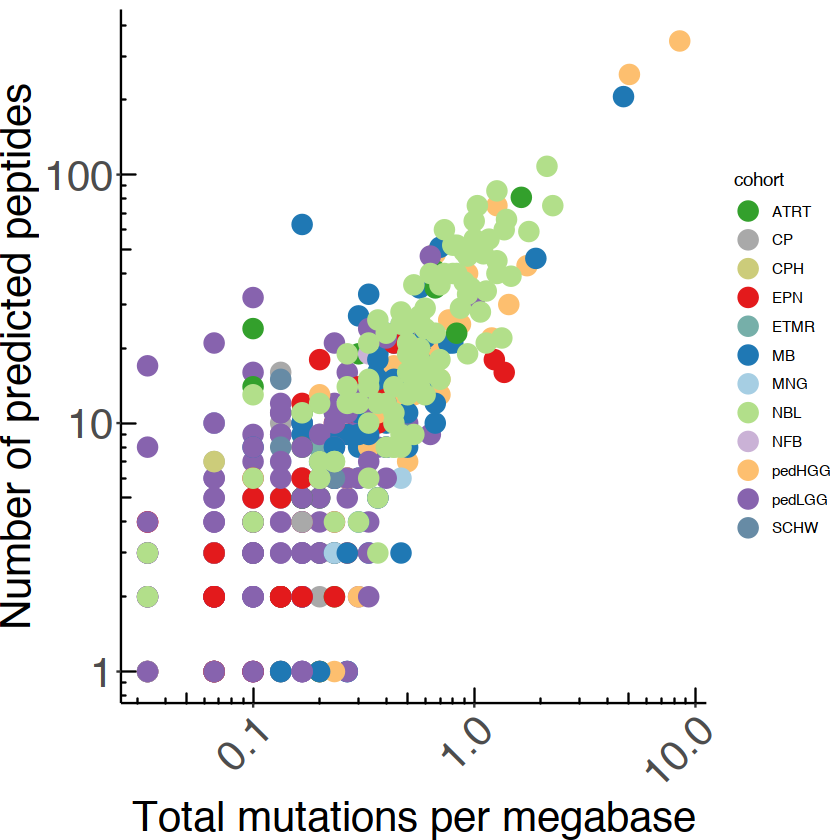

In [34]:
pep_p

In [35]:
pdf(file = paste0(plotpath,"peptide_TMB_plot.pdf"),
    width = 10, 
    height = 10,
    useDingbats = FALSE)
pep_p
dev.off()

pdf 
  2

In [36]:
rcorr(ped_peptide$mutpermb, ped_peptide$peptides_SB,  type = "spearman")

     x    y
x 1.00 0.77
y 0.77 1.00

n= 456 


P
  x  y 
x     0
y  0   

## Correlation of div with number of peptides

for now remove dkfz

In [23]:
pedtrb <- primary_estimate_manifest_quanti_TRB[primary_estimate_manifest_quanti_TRB$group != "TCGA",]
pedtrb <- pedtrb[pedtrb$ImmuneScore > -1000,]

Subset to samples included in the study

In [24]:
dim(pedtrb)

[1] 334  45

In [25]:
div_trb <- merge(ped,
                 pedtrb[,c("sample_id", "estimated_Shannon", "IDis", "Reads")],
                 by = "sample_id")

In [26]:
div_trb <- div_trb[div_trb$group != "DKFZ",]

In [27]:
dim(div_trb)

[1] 250  45

In [28]:
bindersamples <- all.mupexi[all.mupexi$Mut_MHCbinder == "SB",]

In [29]:
# subest to include only those samples with available mupexi files and having Strong binders
div_trb <- div_trb[ div_trb$sample_id %in% bindersamples$sample_id,]

In [30]:
dim(div_trb)

[1] 184  45

In [37]:
#some of these samples dont have predicted peptides with SB
tmp <- as.data.frame(table(bindersamples$sample_id), stringsAsFactors = F)

In [38]:
div_trb$binders <- NA

for(i in 1:nrow(tmp)){
    div_trb$binders[match(tmp$Var1[i],div_trb$sample_id)] <- tmp$Freq[i]   
}

div_trb$binders[is.na(div_trb$binders)] <- 0

In [39]:
colnames(div_trb)

[1] "sample_id"         "aliquot_id"        "StromalScore"     
 [4] "ImmuneScore"       "ESTIMATEScore"     "name"             
 [7] "case_id"           "gender"            "ethnicity"        
[10] "race"              "age_at_diagnosis"  "vital_status"     
[13] "days_to_death"     "days_to_progress"  "recurrence"       
[16] "disease_type"      "primary_site"      "group"            
[19] "cohort"            "sample_type"       "age_class"        
[22] "B.cells"           "Macrophages.M1"    "Macrophages.M2"   
[25] "Monocytes"         "Neutrophils"       "NK.cells"         
[28] "T.cells.CD4"       "T.cells.CD8"       "Tregs"            
[31] "Dendritic.cells"   "Other"             "Frame_Shift_Del"  
[34] "Frame_Shift_Ins"   "In_Frame_Del"      "In_Frame_Ins"     
[37] "Missense_Mutation" "Nonsense_Mutation" "Nonstop_Mutation" 
[40] "total"             "mutpermb"          "snvpermb"         
[43] "estimated_Shannon" "IDis"              "Reads"            
[46] "binders"

In [40]:
div_trb[div_trb$mutpermb > 5,]

,sample_id,aliquot_id,StromalScore,ImmuneScore,ESTIMATEScore,name,case_id,gender,ethnicity,race,⋯,Missense_Mutation,Nonsense_Mutation,Nonstop_Mutation,total,mutpermb,snvpermb,estimated_Shannon,IDis,Reads,binders
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
82,7316-2307,731934,-363.0196,746.5124,383.4928,69bf374c-b410-4513-a83c-adbe98ae0a4e.rsem.genes.results,C621765,Female,Not Hispanic or Latino,White,⋯,377,24,0,499,16.617606,13.354028,13.958,0.3795167,9,638
94,7316-2594,574553,-980.8383,162.8998,-817.9385,b3a8b89c-d86c-4c07-a924-7c9a17e3bfdd.rsem.genes.results,C714384,Male,Not Hispanic or Latino,White,⋯,115,3,0,151,5.028574,3.929614,7.799,0.5590170,8,181


In [41]:
rcorr(div_trb$estimated_Shannon, div_trb$binders,  type = "spearman")

     x    y
x 1.00 0.14
y 0.14 1.00

n= 184 


P
  x      y     
x        0.0524
y 0.0524       

In [37]:
pep_div_p <- ggplot(data = div_trb, aes(y = estimated_Shannon, x = binders, color = cohort, size = mutpermb)) + 
geom_point() + mytheme +
scale_y_continuous(trans = "log10") + 
scale_x_continuous(trans = "log10") +
annotation_logticks(sides = "bl") +
scale_color_manual(values = colpal) +
scale_size_continuous(range = c(3, 15), breaks=c(0.2,1,2, 10)) +
labs( x = "Number of predicted peptides", y = "Inferred Shannon diversity")

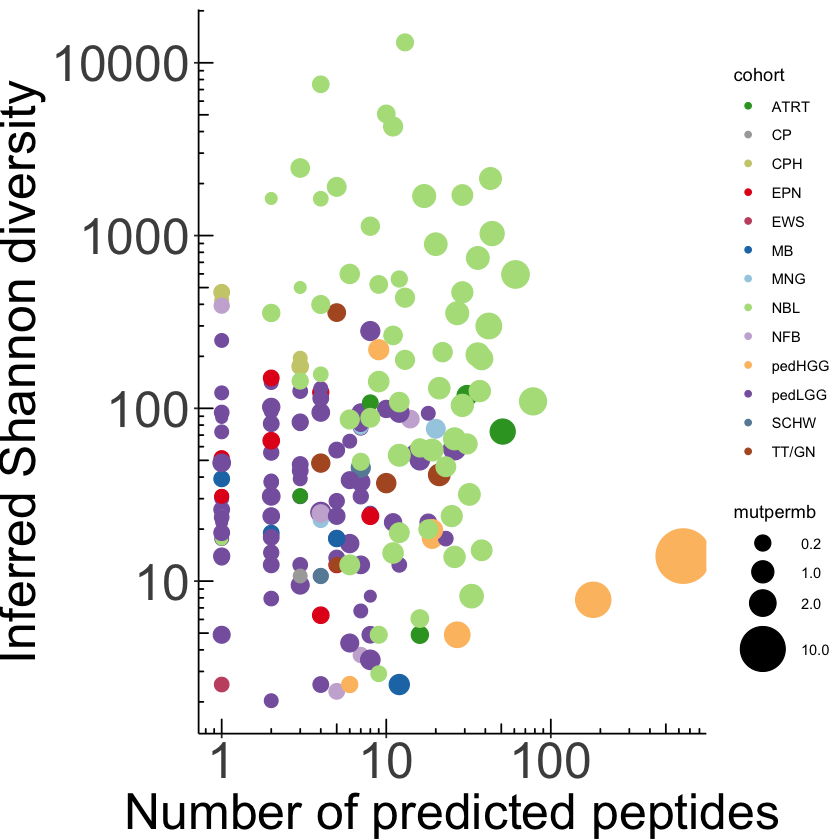

In [38]:
pep_div_p

In [101]:
pdf(file = paste0(plotpath,"peptide_TMB_TRBdiv_plot.pdf"),
    width = 10, 
    height = 10,
    useDingbats = FALSE)
pep_div_p
dev.off()

pdf 
  2

## Peptide mhcs and their frequencies

In [21]:
all.mupexi$pMHC <- paste(all.mupexi$Mut_peptide, all.mupexi$HLA_allele, sep = "_")

In [22]:
colnames(all.mupexi)

[1] "HLA_allele"             "Norm_peptide"           "Norm_MHCrank_EL"       
 [4] "Norm_MHCscore_EL"       "Norm_MHCaffinity"       "Norm_MHCrank_BA"       
 [7] "Norm_MHCscore_BA"       "Mut_peptide"            "Mut_MHCrank_EL"        
[10] "Mut_MHCscore_EL"        "Mut_MHCaffinity"        "Mut_MHCrank_BA"        
[13] "Mut_MHCscore_BA"        "Gene_ID"                "Transcript_ID"         
[16] "Amino_Acid_Change"      "Allele_Frequency"       "Mismatches"            
[19] "peptide_position"       "Chr"                    "Genomic_Position"      
[22] "Protein_position"       "Mutation_Consequence"   "Gene_Symbol"           
[25] "Cancer_Driver_Gene"     "Proteome_Peptide_Match" "Expression_Level"      
[28] "Mutant_affinity_score"  "Normal_affinity_score"  "Expression_score"      
[31] "priority_Score"         "Norm_MHCbinder"         "Mut_MHCbinder"         
[34] "sample_id"              "pMHC"

In [23]:
tmp <- all.mupexi[,c("pMHC", "Gene_Symbol", "Amino_Acid_Change", "Protein_position")]

In [24]:
head(tmp)

pMHC,Gene_Symbol,Amino_Acid_Change,Protein_position
<chr>,<chr>,<chr>,<chr>
RFIFGVVGNL_HLA-A23:01,PTGER4,M/R,27
VTIPAVRFIF_HLA-B58:02,PTGER4,M/R,27
VTIPAVRFI_HLA-B58:02,PTGER4,M/R,27
REPPALQY_HLA-B44:03,ENTPD2,K/Q,"39,39"
VREPPALQY_HLA-C06:02,ENTPD2,K/Q,"39,39"
TIPAVRFIF_HLA-A23:01,PTGER4,M/R,27


In [25]:
pMHC_common <- as.data.frame(table(all.mupexi$pMHC), stringsAsFactors = F)

pMHC_common <- pMHC_common[pMHC_common$Freq > 2,]

colnames(pMHC_common) <- c("pMHC", "Frequency")

In [26]:
pMHC_common_merged <- merge(pMHC_common, tmp, by = "pMHC")

In [27]:
pMHC_common_table <- pMHC_common_merged[!duplicated(pMHC_common_merged$pMHC),]

In [30]:
head(pMHC_common)

,pMHC,Frequency
,<chr>,<int>
114,AARMSAPST_HLA-B07:02,6
1162,ATKAARMSA_HLA-B07:02,6
2642,EKSRWSGSHQF_HLA-B27:05,4
6399,IGDFGLATEK_HLA-A03:01,6
7606,KIGDFGLATEK_HLA-A03:01,6
7827,KPIIIGHHA_HLA-B07:02,3


In [302]:
write.csv(pMHC_common_table, paste0(datapath,"Mupexi/pMHC_common_table.csv"), row.names = FALSE)

# TableS5

In [34]:
tables5 <- all.mupexi[all.mupexi$Mut_MHCbinder == "SB" ,]

In [35]:
tables5$pMHC <- paste(tables5$Mut_peptide, tables5$HLA_allele, sep = "_")

In [32]:
colnames(bindersamples)

[1] "HLA_allele"             "Norm_peptide"           "Norm_MHCrank_EL"       
 [4] "Norm_MHCscore_EL"       "Norm_MHCaffinity"       "Norm_MHCrank_BA"       
 [7] "Norm_MHCscore_BA"       "Mut_peptide"            "Mut_MHCrank_EL"        
[10] "Mut_MHCscore_EL"        "Mut_MHCaffinity"        "Mut_MHCrank_BA"        
[13] "Mut_MHCscore_BA"        "Gene_ID"                "Transcript_ID"         
[16] "Amino_Acid_Change"      "Allele_Frequency"       "Mismatches"            
[19] "peptide_position"       "Chr"                    "Genomic_Position"      
[22] "Protein_position"       "Mutation_Consequence"   "Gene_Symbol"           
[25] "Cancer_Driver_Gene"     "Proteome_Peptide_Match" "Expression_Level"      
[28] "Mutant_affinity_score"  "Normal_affinity_score"  "Expression_score"      
[31] "priority_Score"         "Norm_MHCbinder"         "Mut_MHCbinder"         
[34] "sample_id"

In [36]:
cols <- c("sample_id", "pMHC", "Gene_Symbol", "Amino_Acid_Change", "Protein_position")

In [37]:
tables5 <- tables5[,cols]

In [38]:
tables5$sample_id <- gsub("7316", "X7316", tables5$sample_id)

In [41]:
dim(tables5)

[1] 5513    5

In [40]:
write.csv(tables5,
          file = paste0(datapath, "TableS5.csv"),row.names = FALSE)

# Numbers in text

In [14]:
table(all.mupexi$Mut_MHCbinder[all.mupexi$sample_id %in% ped$sample_id])


   SB    WB 
 5513 15477 

In [21]:
rcorr(ped_peptide$mutpermb, ped_peptide$peptides_SB,  type = "spearman")

     x    y
x 1.00 0.74
y 0.74 1.00

n= 455 


P
  x  y 
x     0
y  0   

In [42]:
rcorr(div_trb$estimated_Shannon, div_trb$binders,  type = "spearman")

     x    y
x 1.00 0.14
y 0.14 1.00

n= 184 


P
  x      y     
x        0.0524
y 0.0524       

# Deprecated

In [29]:
div_trb_narm <- div_trb[!is.na(div_trb$binderbin),]

In [112]:
for(i in unique(div_trb_narm$cohort)){
    message(i)
    tmp <- div_trb_narm[div_trb_narm$cohort == i,]
     wtest <- tryCatch(t.test(tmp$estimated_Shannon ~ tmp$binderbin), error = function(e) NULL)   
    print(wtest)
}

NFB



	Welch Two Sample t-test

data:  tmp$estimated_Shannon by tmp$binderbin
t = -0.57386, df = 4.9489, p-value = 0.5912
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -271.0113  172.3429
sample estimates:
    mean in group Binder mean in group Not Binder 
                 44.4720                  93.8062 



pedLGG



	Welch Two Sample t-test

data:  tmp$estimated_Shannon by tmp$binderbin
t = -0.11326, df = 54.652, p-value = 0.9102
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -26.18424  23.38321
sample estimates:
    mean in group Binder mean in group Not Binder 
                51.03755                 52.43807 



CPH


NULL


TT/GN



	Welch Two Sample t-test

data:  tmp$estimated_Shannon by tmp$binderbin
t = 1.0411, df = 1.0058, p-value = 0.4864
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -1849.056  2184.059
sample estimates:
    mean in group Binder mean in group Not Binder 
                197.5605                  30.0590 



pedHGG



	Welch Two Sample t-test

data:  tmp$estimated_Shannon by tmp$binderbin
t = 1.2619, df = 5.0119, p-value = 0.2625
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -44.91431 131.65697
sample estimates:
    mean in group Binder mean in group Not Binder 
                47.07683                  3.70550 



ATRT


NULL


MB



	Welch Two Sample t-test

data:  tmp$estimated_Shannon by tmp$binderbin
t = -1.1431, df = 2.8333, p-value = 0.3403
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -50.03488  24.23688
sample estimates:
    mean in group Binder mean in group Not Binder 
                  10.070                   22.969 



EPN



	Welch Two Sample t-test

data:  tmp$estimated_Shannon by tmp$binderbin
t = -2.2899, df = 6.7505, p-value = 0.05717
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -96.651876   1.914447
sample estimates:
    mean in group Binder mean in group Not Binder 
                18.10600                 65.47471 



MNG


NULL


SCHW


NULL


CP


NULL


NBL



	Welch Two Sample t-test

data:  tmp$estimated_Shannon by tmp$binderbin
t = 0.94248, df = 52.239, p-value = 0.3503
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -428.4234 1187.4525
sample estimates:
    mean in group Binder mean in group Not Binder 
                999.3554                 619.8408 



EWS


NULL


In [1465]:
colpal <- c("MB_PDX" = "#878787", #PDX
            "ETMR" = "#76afa9", #ped
            "MNG" = "#a6cee3", 
            "MB" =  "#1f78b4",
            "SCHW" =  "#678ba5",
            "ATRT" =  "#33a02c",
            "EPN" = "#e31a1c",
            "pedHGG" = "#fdbf6f",
            "pedLGG" = "#8763ae",
            "NFB" = "#cab2d6",
            "CPH" = "#cccc7a",
            "TT/GN" = "#b15928",
            "CP" = "#a9a9a9",
            "NBL" = "#b2df8a",
            "EWS" = "#C65370",
            
            "SKCM" = "#7c9c60", #Adult
            "LGG" = "#753a00",
            "GBM" = "#6a3d9a",
            "OV" = "#afaf78",
            "PRAD" = "#a85426",
            "LUAD" = "#ad3837",
            "COAD" = "#726579",
            "EMPTY1" = "#FFFFFF",
            "EMPTY2" = "#FFFFFF")

In [1466]:
beeswarm_binders_all <- ggplot(data = div_trb_narm, aes(x = binderbin, y = estimated_Shannon)) +
geom_beeswarm(aes(fill = cohort, color = cohort),
              alpha = 1, cex = 3, size = 5) + 
geom_boxplot(
    outlier.shape = NA, 
             width = 0.5, 
             color = "black", 
             alpha = 0.1,
             show.legend = FALSE) + 
theme(axis.title.x = element_blank(),
      axis.title.y = element_text(size = 25),
      axis.ticks.x = element_blank(),
      axis.line = element_line(color = "black"),
      axis.text.y = element_text(size = 25),
      axis.text.x = element_text(angle = 45, hjust = 1, size = 25),
      legend.position = "none",
     legend.text = element_text(size = 20)) +
theme(panel.grid.major = element_blank(),
      panel.grid.minor = element_blank(),
      panel.background = element_rect(fill = "transparent",colour = NA),
      panel.border=element_blank(),
      legend.key = element_rect(fill = "white", colour = "white"),
      plot.margin = unit(c(0.2,0,0,0),"cm")) +
scale_fill_manual(values = colpal) +
scale_color_manual(values = colpal) +
annotation_logticks(sides = "l") +
scale_y_continuous(trans = "log10") +
labs(y = "Shannon div",
    title = "TRB div in samples with neoepitope priority=100,\n Binders > 3 pMHCs, not binders  <= 1 pMHCs") 

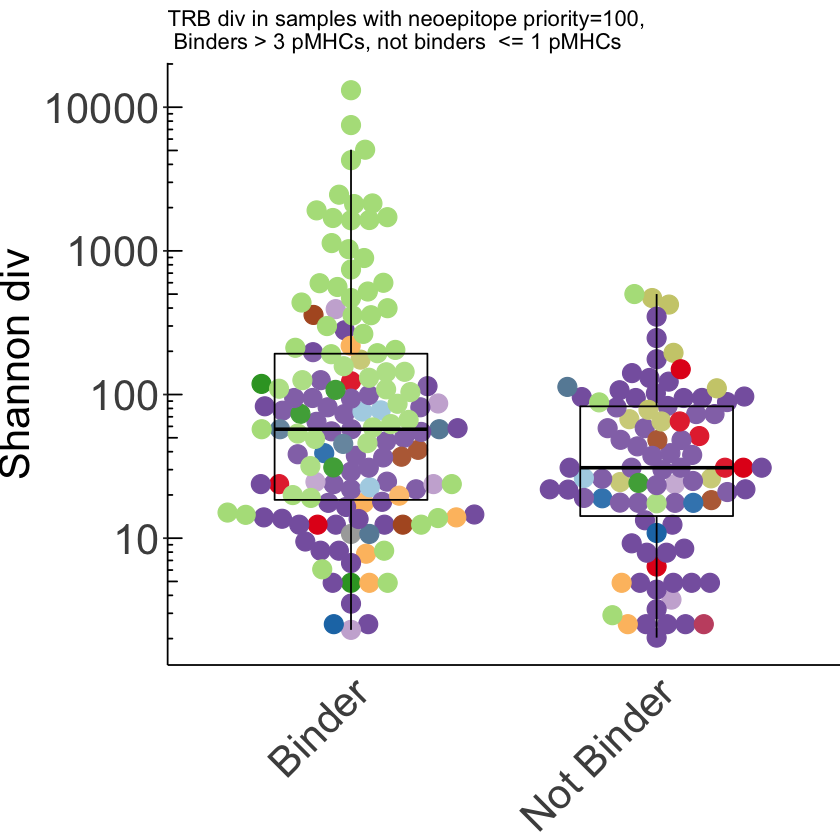

In [1467]:
beeswarm_binders_all

In [1425]:
pdf(file = paste0(plotpath,"beeswarm_TRB_shann_binders_all.pdf"),
    width = 5, 
    height = 10,
    useDingbats = FALSE)
beeswarm_binders_all
dev.off()

pdf 
  2

by cancer types

In [1367]:
colpal <- c("Not Binder" = "#74add1", 
            "Binder" = "#d73027")

In [1368]:
head(div_trb_narm)

,sample_id,aliquot_id,StromalScore,ImmuneScore,ESTIMATEScore,name,case_id,gender,ethnicity,race,⋯,T.cells.CD8,Tregs,Dendritic.cells,Other,percread,estimated_Shannon,IDis,Reads,binders,binderbin
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,7316-10,717108,948.22241,1027.2452,1975.467631,cae75655-bec6-4ab6-af6f-e286f4cae404.rsem.genes.results,C15129,Female,Not Hispanic or Latino,African,⋯,0.000000000,0.001440083,0.000000000,0.9659597,15.40969,3.736,0.3464102,5,0,Not Binder
7,7316-1081,731897,-413.66408,879.1675,465.503384,1da1eb0c-f54d-4bce-8f02-55899fc8761f.rsem.genes.results,C410697,Male,Reported Unknown,Other,⋯,0.000000000,0.000000000,0.027998658,0.9272256,14.04401,24.751,0.5063697,21,6,Binder
8,7316-1082,728285,1943.13080,2326.1879,4269.318697,f22d1fdf-64c6-456c-89e4-95a741ae455e.rsem.genes.results,C409467,Female,Reported Unknown,Other,⋯,0.002099164,0.003734566,0.001243847,0.9563279,34.78004,67.348,1.0723805,122,0,Not Binder
9,7316-1084,731871,633.42795,1509.3116,2142.739585,c8554fc6-c569-4056-a92c-358a9a6ec4a0.rsem.genes.results,C409959,Female,Reported Unknown,Other,⋯,0.000000000,0.000000000,0.059637696,0.8981495,20.84486,247.170,0.2775205,54,0,Not Binder
10,7316-1090,717127,-406.04174,407.7092,1.667443,b75638c2-fdc0-4321-8320-b7b3b7b6940e.rsem.genes.results,C333822,Male,Reported Unknown,Other,⋯,0.000000000,0.005016794,0.031155413,0.9221363,10.45137,58.309,0.2763854,12,0,Not Binder
11,7316-1095,588303,98.81084,1073.0231,1171.833948,24574fa8-71db-45a9-b364-095caa1689f7.rsem.genes.results,C409098,Male,Reported Unknown,Other,⋯,0.000000000,0.000000000,0.018076876,0.9045865,15.85818,94.682,0.4885797,43,0,Not Binder


In [1373]:
tapply(div_trb_narm$binderbin, div_trb_narm$cohort, table)

$ATRT

    Binder Not Binder 
         3          2 

$CP

Not Binder 
         1 

$CPH

Not Binder 
        10 

$EPN

Not Binder 
         8 

$EWS

Not Binder 
         1 

$MB

    Binder Not Binder 
         1          4 

$MNG

    Binder Not Binder 
         2          2 

$NBL

    Binder Not Binder 
        35         13 

$NFB

Not Binder 
         5 

$pedHGG

    Binder Not Binder 
         5          3 

$pedLGG

    Binder Not Binder 
         5         88 

$SCHW

Not Binder 
         3 

$`TT/GN`

    Binder Not Binder 
         1          4 


In [1427]:
# only in cancers with > 2 samples in each group

div_trb_narm_nbl <- div_trb_narm[div_trb_narm$cohort == "NBL",]

In [1428]:
beeswarm_binders_nbl <- ggplot(data = div_trb_narm_nbl, aes(x = binderbin, y = estimated_Shannon)) +
geom_beeswarm(aes(fill = cohort, color = cohort),
              alpha = 1, cex = 3, size = 5) + 
geom_boxplot(
    outlier.shape = NA, 
             width = 0.5, 
             color = "black", 
             alpha = 0.1,
             show.legend = FALSE) + 
theme(axis.title.x = element_blank(),
      axis.title.y = element_text(size = 25),
      axis.ticks.x = element_blank(),
      axis.line = element_line(color = "black"),
      axis.text.y = element_text(size = 25),
      axis.text.x = element_text(angle = 45, hjust = 1, size = 25),
      legend.position = "none",
     legend.text = element_text(size = 20)) +
theme(panel.grid.major = element_blank(),
      panel.grid.minor = element_blank(),
      panel.background = element_rect(fill = "transparent",colour = NA),
      panel.border=element_blank(),
      legend.key = element_rect(fill = "white", colour = "white"),
      plot.margin = unit(c(0.2,0,0,0),"cm")) +
scale_fill_manual(values = colpal) +
scale_color_manual(values = colpal) +
annotation_logticks(sides = "l") +
scale_y_continuous(trans = "log10") +
labs(y = "Shannon div",
    title = "TRB div in samples with neoepitope priority=100,\n Binders > 3 pMHCs, not binders  <= 1 pMHCs") 

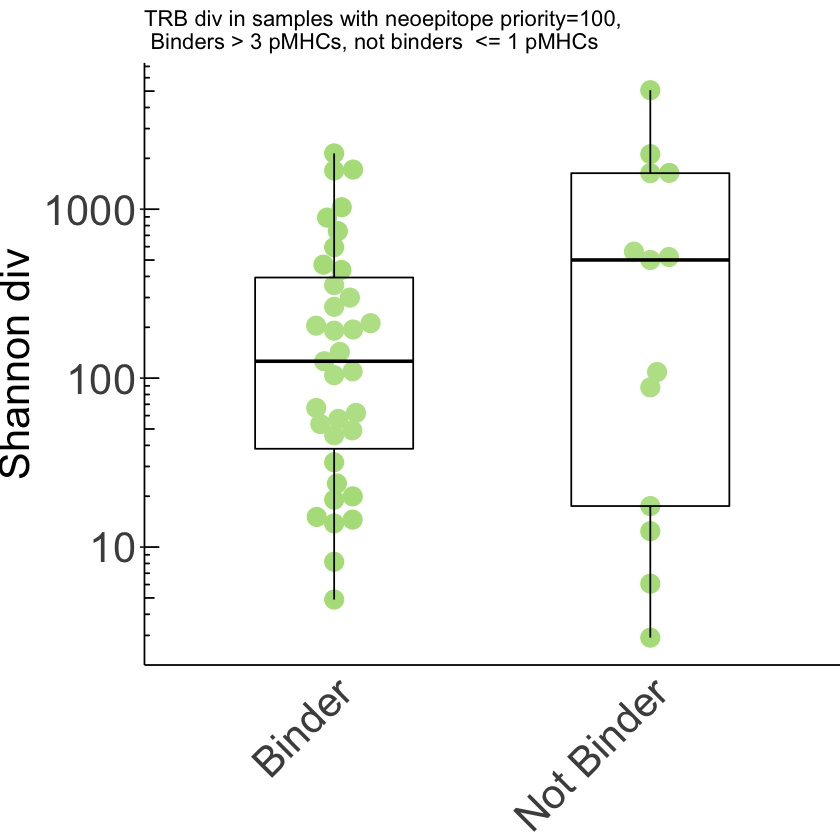

In [1429]:
beeswarm_binders_nbl

In [1396]:
div_trb_narm_m <- melt(div_trb_narm[,c("estimated_Shannon", "cohort", "binderbin")])

Using cohort, binderbin as id variables


In [1397]:
dodge <- position_dodge(width = 0.8)

violinplot_TRB_shann_binders <- ggplot(div_trb_narm_m, 
                      aes(y= value, 
                          x= cohort, 
                          fill = binderbin)) + 
geom_violin(position = dodge, scale = "width")+
geom_boxplot(width= 0.3, 
             outlier.colour=NA, 
             position = dodge) +
theme(axis.title.x = element_blank(),
      axis.title.y = element_text(size = 25),
      axis.line = element_line(color = "black"),
      axis.text.y = element_text(size = 25),
      axis.text.x = element_text(angle = 45, hjust = 1, size = 25),
      legend.position = "bottom",
     legend.text = element_text(size = 20)) +
theme(panel.grid.major = element_blank(),
      panel.grid.minor = element_blank(),
      panel.background = element_rect(fill = "transparent",colour = NA),
      panel.border=element_blank(),
      legend.key = element_rect(fill = "white", colour = "white"),
      plot.margin = unit(c(0.2,0,0,0),"cm")) +
scale_fill_manual(values = colpal) + 
labs(y = "Shannon div", x = "cohort",
    title = "TRB div in samples with neoepitope") +
scale_y_continuous(trans = "log10") + 
annotation_logticks(sides = "l")

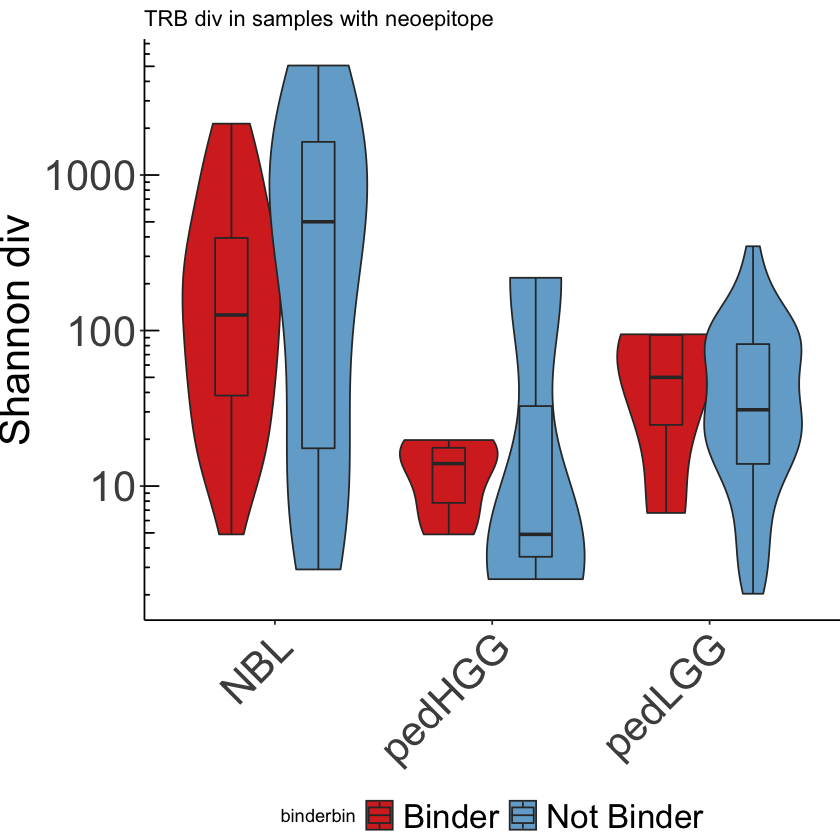

In [1398]:
violinplot_TRB_shann_binders